# Logistic Regression Classifier

The goal of this notebook is to classify our samples using a Logistic Regression model. We will attempt 3 different variations in terms of target variables.

1. Each individual accent
2. Consolidated accents (North, Mid, South, West)
3. Further consolidated regions (East, west)




In [1]:
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, pairwise_distances, confusion_matrix

from matplotlib.colors import ListedColormap


from sklearn.linear_model import LogisticRegression


In [2]:
def plot_conf_matconf(conf_mat, save_fig=None):
    fig = plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells

    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)

    if save_fig:
        plt.savefig(f'{save_fig}.png')

    plt.show()

In [3]:
def average_speakers(mfcc_df):
    feature_cols = [x for x in mfcc_df.columns if 'feature' in x]
    
    target = mfcc_df[['speaker', 'accent']].drop_duplicates()
    
    mfcc_grouped = mfcc_df.groupby(['speaker', 'word'])[feature_cols].mean().reset_index()
    
    joined = pd.merge(how='left', left=mfcc_grouped, right = target, left_on='speaker', right_on = 'speaker')
    
    return joined




def load_data():
    train = pd.read_csv('all_words_train_mfcc.csv')
    test = pd.read_csv('all_words_test_mfcc.csv')
    
    train = train.loc[train['accent'] != 'DR8']
    test = test.loc[test['accent'] != 'DR8']
    test = test.loc[test.word.isin(train.word)].reset_index()
    
    train = average_speakers(train)
    
    british_df = pd.read_csv('british_mfcc.csv')
    feature_cols = [x for x in british_df.columns if 'feature' in x]
    
    return train, test, british_df[feature_cols]


train, test, british_df = load_data()

In [4]:
test.shape # 13596
print(british_df.shape)
test.loc[test['word'].isin(train['word'])].shape

(732, 12)


(10854, 18)

In [5]:
train.accent.value_counts()

DR7    5821
DR3    5784
DR2    5720
DR5    5292
DR4    5090
DR1    2874
DR6    2647
Name: accent, dtype: int64

In [6]:
test.accent.value_counts()

DR4    2146
DR5    1923
DR3    1857
DR2    1826
DR7    1552
DR6     777
DR1     773
Name: accent, dtype: int64

In [7]:
def logistic_reg(train, test, display_conf=True, word=None, features = None):
    if features:
        feature_cols = features
        
    else:
        feature_cols = [x for x in train.columns if 'feature' in x]

    if word:
        train = train.loc[train['word'] == word]
        test = test.loc[test['word'] == word]
        
    
    X_train = train[feature_cols]
    y_train = train['accent']
    
    X_test = test[feature_cols]
    y_test = test['accent']
    
    logit = LogisticRegression(max_iter = 1250, class_weight='balanced')
    C = np.logspace(0, 4, 10)
    hyperparameters = dict(C=C)

    clf = GridSearchCV(logit, hyperparameters, cv=5, verbose=0)

    best_model = clf.fit(X_train, y_train)

    # View best hyperparameters
    print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
    print('Best C:', best_model.best_estimator_.get_params()['C'])
                           
    y_pred = best_model.predict(X_test)
    
    conf_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

    if display_conf:
        conf_mat = confusion_matrix(y_test, y_pred)
        plot_conf_matconf(conf_mat)
    
        print("Logistic Reg Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))    
        print(conf_df)
    
    
    return best_model, y_pred, conf_df





Best Penalty: l2
Best C: 21.544346900318832


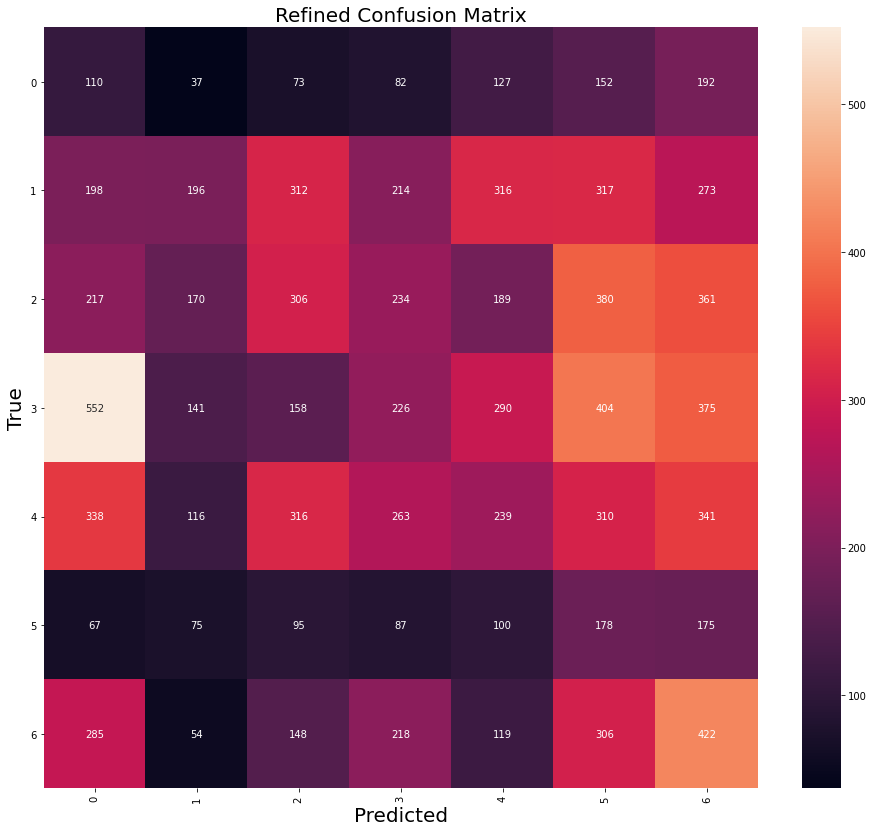

Logistic Reg Number of mislabeled points out of a total 10854 points : 9177
                  DR1          DR2          DR3          DR4          DR5  \
precision    0.062252     0.248416     0.217330     0.170695     0.173188   
recall       0.142303     0.107338     0.164782     0.105312     0.124285   
f1-score     0.086614     0.149904     0.187443     0.130259     0.144717   
support    773.000000  1826.000000  1857.000000  2146.000000  1923.000000   

                  DR6          DR7  accuracy     macro avg  weighted avg  
precision    0.086957     0.197288  0.154505      0.165161      0.182276  
recall       0.229086     0.271907  0.154505      0.163573      0.154505  
f1-score     0.126062     0.228664  0.154505      0.150523      0.156571  
support    777.000000  1552.000000  0.154505  10854.000000  10854.000000  


In [8]:
logit_whole, logit_y_pred_whole, logit_conf_whole = logistic_reg(train, test)


In [9]:
british_pred = logit_whole.predict(british_df)

In [10]:
whole_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

whole_pred['pred_tally'] = 1

print(whole_pred['pred_accent'].value_counts())


whole_bp = whole_pred.groupby('pred_accent').sum()
whole_bp['pred_percent'] = whole_bp['pred_tally'] / whole_bp['pred_tally'].sum() * 100.00

whole_bp.head(10)

DR7    586
DR6     96
DR2     49
DR5      1
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
DR2,49,6.693989
DR5,1,0.136612
DR6,96,13.114754
DR7,586,80.054645


In [11]:
consolidate_region_map = {
    'DR1': 'North',
    'DR2': 'North',
    'DR3': 'Mid',
    'DR4': 'Mid',
    'DR5': 'South',
    'DR6': 'North',
    'DR7': 'West',
}



def consolidate_regions(train, test, dict_map):
    condensed_train = train.copy()
    condensed_train['region'] = condensed_train['accent'].map(dict_map)
    condensed_train['accent'] = condensed_train['region']
    
    condensed_test = test.copy()
    condensed_test['region'] = condensed_test['accent'].map(dict_map)
    condensed_test['accent'] = condensed_test['region']
    
    return condensed_train, condensed_test


In [12]:
condensed_train, condensed_test = consolidate_regions(train, test, consolidate_region_map)

condensed_test.accent.value_counts()

Mid      4003
North    3376
South    1923
West     1552
Name: accent, dtype: int64

Best Penalty: l2
Best C: 1291.5496650148827


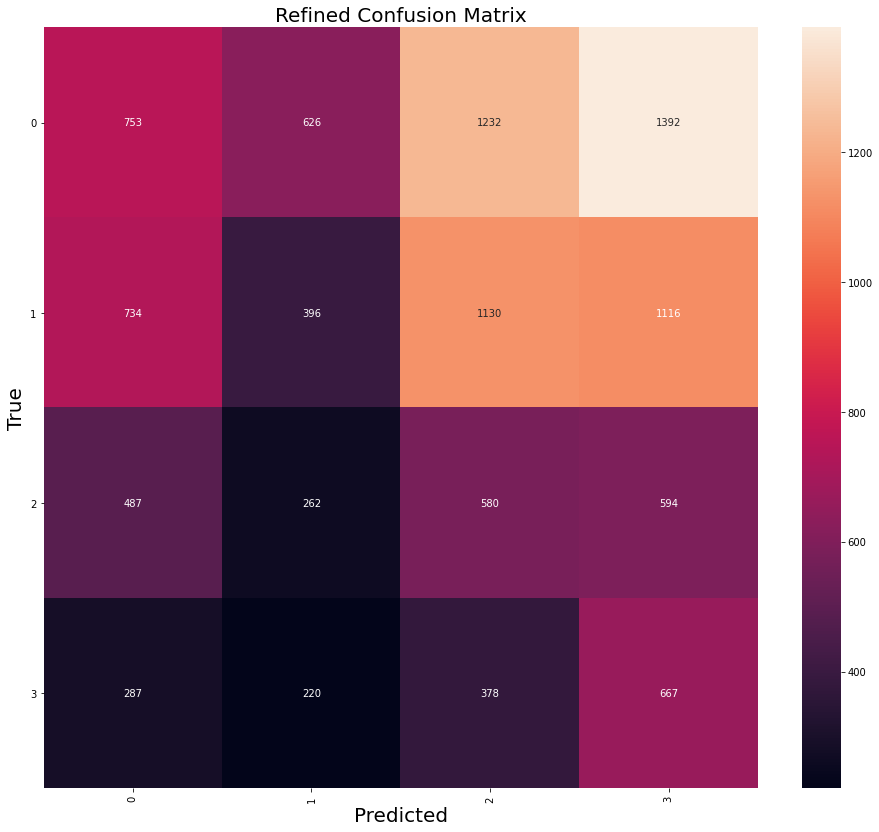

Logistic Reg Number of mislabeled points out of a total 10854 points : 8458
                   Mid        North        South         West  accuracy  \
precision     0.333038     0.263298     0.174699     0.176970  0.220748   
recall        0.188109     0.117299     0.301612     0.429768  0.220748   
f1-score      0.240421     0.162295     0.221247     0.250705  0.220748   
support    4003.000000  3376.000000  1923.000000  1552.000000  0.220748   

              macro avg  weighted avg  
precision      0.237001      0.260978  
recall         0.259197      0.220748  
f1-score       0.218667      0.214195  
support    10854.000000  10854.000000  


In [13]:
logit_condensed, logit_y_pred_condensed, logit_conf_condensed = logistic_reg(condensed_train, condensed_test)


In [14]:
british_pred = logit_condensed.predict(british_df)


condensed_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

condensed_pred['pred_tally'] = 1

print(condensed_pred['pred_accent'].value_counts())


condensed__sum = condensed_pred.groupby('pred_accent').sum()
condensed__sum['pred_percent'] = condensed__sum['pred_tally'] / condensed__sum['pred_tally'].sum() * 100.00

condensed__sum.head(10)


West     704
South     14
North     14
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
North,14,1.912568
South,14,1.912568
West,704,96.174863


In [15]:
consolidate_mas = {
    'North': 'East',
    'Mid': 'East',
    'South': 'East',
    'West': 'West',
}


condensed_train_two_regions, condensed_tes_two_regions = consolidate_regions(condensed_train, condensed_test, consolidate_mas)


condensed_train_two_regions.accent.value_counts()

East    27407
West     5821
Name: accent, dtype: int64

Best Penalty: l2
Best C: 1.0


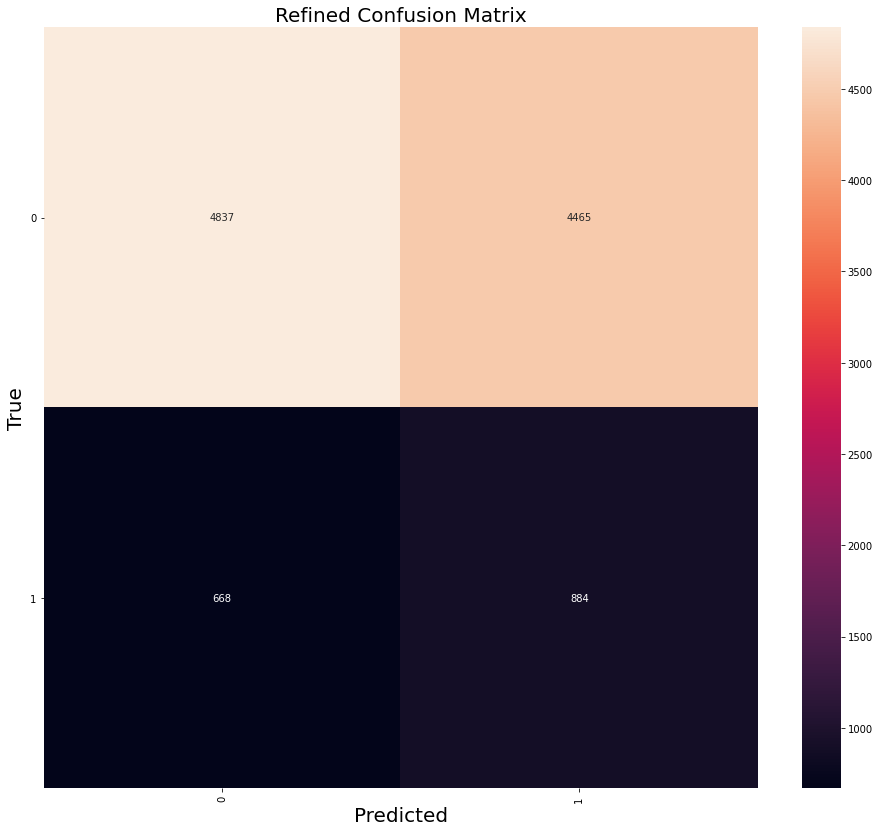

Logistic Reg Number of mislabeled points out of a total 10854 points : 5133
                  East         West  accuracy     macro avg  weighted avg
precision     0.878656     0.165265  0.527087      0.521960      0.776649
recall        0.519996     0.569588  0.527087      0.544792      0.527087
f1-score      0.653340     0.256195  0.527087      0.454767      0.596552
support    9302.000000  1552.000000  0.527087  10854.000000  10854.000000


In [16]:
logit_cm, logit_y_pred_cm, logit_conf_cm = logistic_reg(condensed_train_two_regions, condensed_tes_two_regions)


In [17]:
british_pred = logit_cm.predict(british_df)


cm_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

cm_pred['pred_tally'] = 1

print(cm_pred['pred_accent'].value_counts())


cm_pred__sum = cm_pred.groupby('pred_accent').sum()
cm_pred__sum['pred_percent'] = cm_pred__sum['pred_tally'] / cm_pred__sum['pred_tally'].sum() * 100.00

cm_pred__sum.head(10)

West    714
East     18
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
East,18,2.459016
West,714,97.540984
